**классификатор изображений на основе свёрточной сети**

Евгений Борисов <esborisov@sevsu.ru>

---

Backpropagation applied to handwritten zip code recognition.    
LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.   
Neural Computation 1989 1(4):541-551.  

http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf   

---

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

## загружаем датасет

In [2]:
# from tensorflow.keras.datasets import fashion_mnist
# (image_train, target_train),(image_test, target_test) = fashion_mnist.load_data()
# image_train = image_train[:,:,:,np.newaxis]
# image_test = image_test[:,:,:,np.newaxis]
# target_train = target_train.flatten()
# target_test = target_test.flatten()

In [3]:
from tensorflow.keras.datasets import cifar10

(image_train, target_train),(image_test, target_test) = cifar10.load_data()

target_train = target_train.flatten()
target_test = target_test.flatten()

image_train.shape, image_test.shape

2022-11-04 13:44:01.197941: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 13:44:01.313553: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 13:44:01.804358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64::/opt/cuda/lib64
2022-11-04 13:44:01.804428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

((50000, 32, 32, 3), (10000, 32, 32, 3))

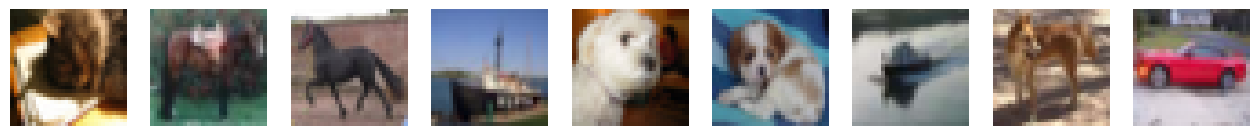

In [4]:
n_show = 9

plt.figure(figsize=(16,4))
for n,i in enumerate(rng.permutation(len(image_train))[:n_show], start=1):
    img = image_train[i]
    plt.subplot(1,n_show,n)
    plt.axis(False)
    plt.imshow(img) # ,cmap='gray_r')


In [5]:
image_train.min(),image_train.max()

(0, 255)

## подготовка данных

In [6]:
# масштабируем данные в [-1,1], добавляем ещё одну размерность (канал цвета)

im2ar = lambda im: (im-127.5)/127.5

x_train = im2ar(image_train).astype(np.float32)
x_test  = im2ar(image_test).astype(np.float32)

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
x_train.min(),x_train.max()

(-1.0, 1.0)

In [8]:
# # one hot encoding
# y_train = np.eye(len(target_train),target_train.max()+1,dtype=np.float32)[target_train]
# y_test = np.eye(len(target_test),target_train.max()+1,dtype=np.float32)[target_test]
# y_train.shape, y_test.shape

In [9]:
# one hot encoding
y_train = np.eye(target_train.max()+1,dtype=np.float32)[target_train]
y_test = np.eye(target_train.max()+1,dtype=np.float32)[target_test]
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

## Модель

In [10]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [11]:
# from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [12]:
INPUT_SHAPE = x_train.shape[1:] # размер входного образа
N_CLASSES = y_train.shape[1] # размер выхода

In [13]:
model = Sequential()
model.add(Input( shape=INPUT_SHAPE, name='input1' ) )
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1', ))
model.add(MaxPooling2D(pool_size=2,strides=2, name='mpool1',))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2', ))
model.add(Flatten(name='flatten1'))
model.add(Dense(512,activation='relu',name='hidden1',))
model.add(Dense(N_CLASSES, activation='softmax',name='out_softmax',))

2022-11-04 13:44:05.216394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:44:05.235525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:44:05.235683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 13:44:05.236214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

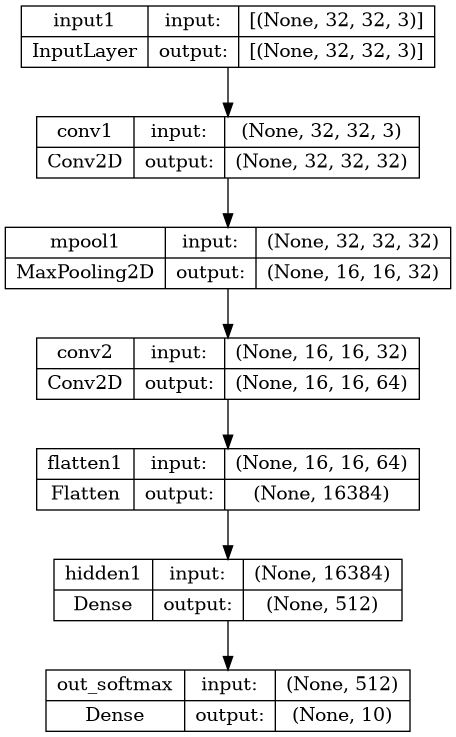

In [14]:
# model.summary()
plot_model(model,to_file='cnn.png', show_layer_names=True, show_shapes=True )

## Обучение

In [15]:
%%time

N_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
VALIDATION_SPLIT = .2
LEARNING_RATE = 2e-4

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, 
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

Epoch 1/20


2022-11-04 13:44:07.374614: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


313/313 [==============================] - 6s 12ms/step - loss: 0.2494 - accuracy: 0.4444 - val_loss: 0.2194 - val_accuracy: 0.5136
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1986 - accuracy: 0.5761 - val_loss: 0.1997 - val_accuracy: 0.5673
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1801 - accuracy: 0.6206 - val_loss: 0.1830 - val_accuracy: 0.6085
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1664 - accuracy: 0.6549 - val_loss: 0.1762 - val_accuracy: 0.6260
Epoch 5/20
313/313 [==============================] - 3s 11ms/step - loss: 0.1548 - accuracy: 0.6843 - val_loss: 0.1662 - val_accuracy: 0.6535
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1434 - accuracy: 0.7116 - val_loss: 0.1639 - val_accuracy: 0.6549
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.1339 - accuracy: 0.7365 - val_loss: 0.1585 - val_accuracy: 0.6713
Epoch 8/20

## Тестирование

In [16]:
x_test.shape

(10000, 32, 32, 3)

In [17]:
score = model.evaluate(x_test, y_test, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.6930999755859375


In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

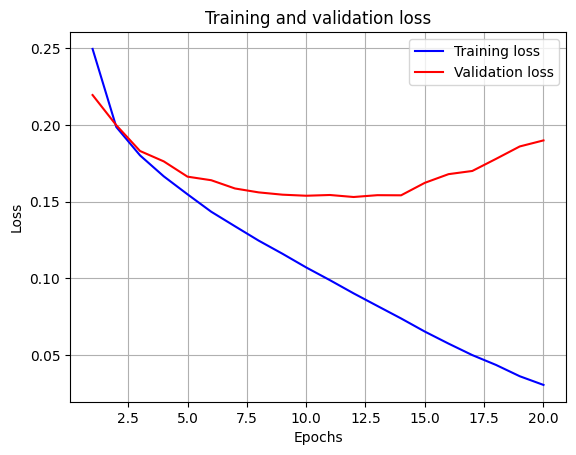

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

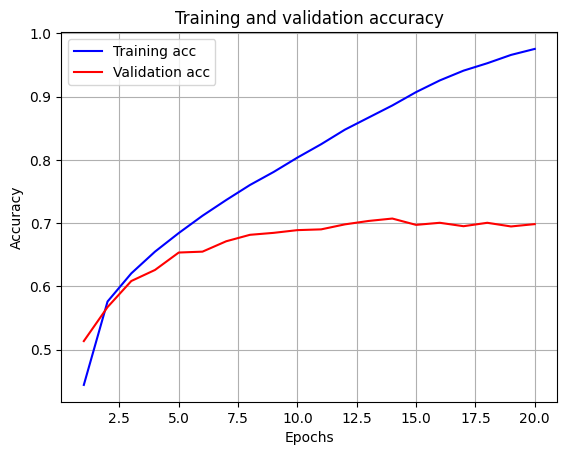

In [20]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

---

In [21]:
%%time 

o_test = np.argmax( model.predict(x_test),axis=1)

class_names = [ 
'airplane',
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]
from sklearn.metrics import classification_report

print(classification_report(target_test, o_test, target_names=class_names) ) 

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

    airplane       0.68      0.80      0.74      1000
  automobile       0.78      0.83      0.80      1000
        bird       0.60      0.54      0.57      1000
         cat       0.47      0.54      0.50      1000
        deer       0.71      0.58      0.64      1000
         dog       0.57      0.62      0.59      1000
        frog       0.78      0.75      0.77      1000
       horse       0.75      0.75      0.75      1000
        ship       0.83      0.79      0.81      1000
       truck       0.82      0.72      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000

CPU times: user 1.04 s, sys: 133 ms, total: 1.18 s
Wall time: 1.13 s


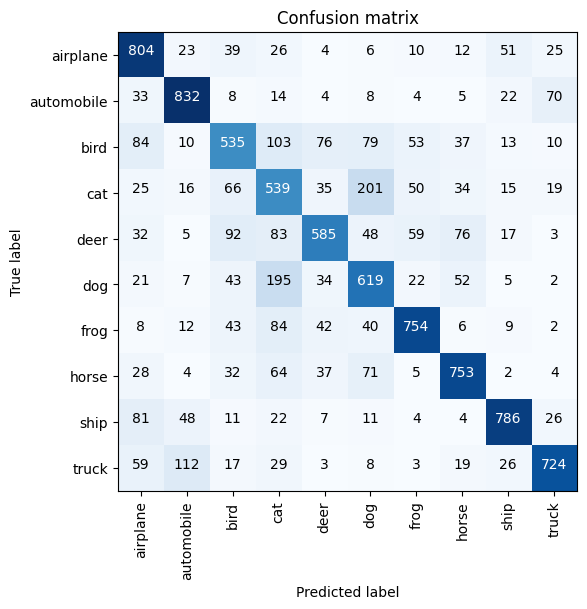

In [22]:
# матрица ошибок
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test,o_test)

classes=class_names
thresh = cm.max()/2.
tick_marks = np.arange(len(classes))

fig = plt.figure(figsize=(6,6))
plt.title('Confusion matrix')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    c = 'white' if cm[i,j] > thresh else 'black'
    plt.text(j,i, f'{cm[i,j]}',horizontalalignment="center",color=c)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

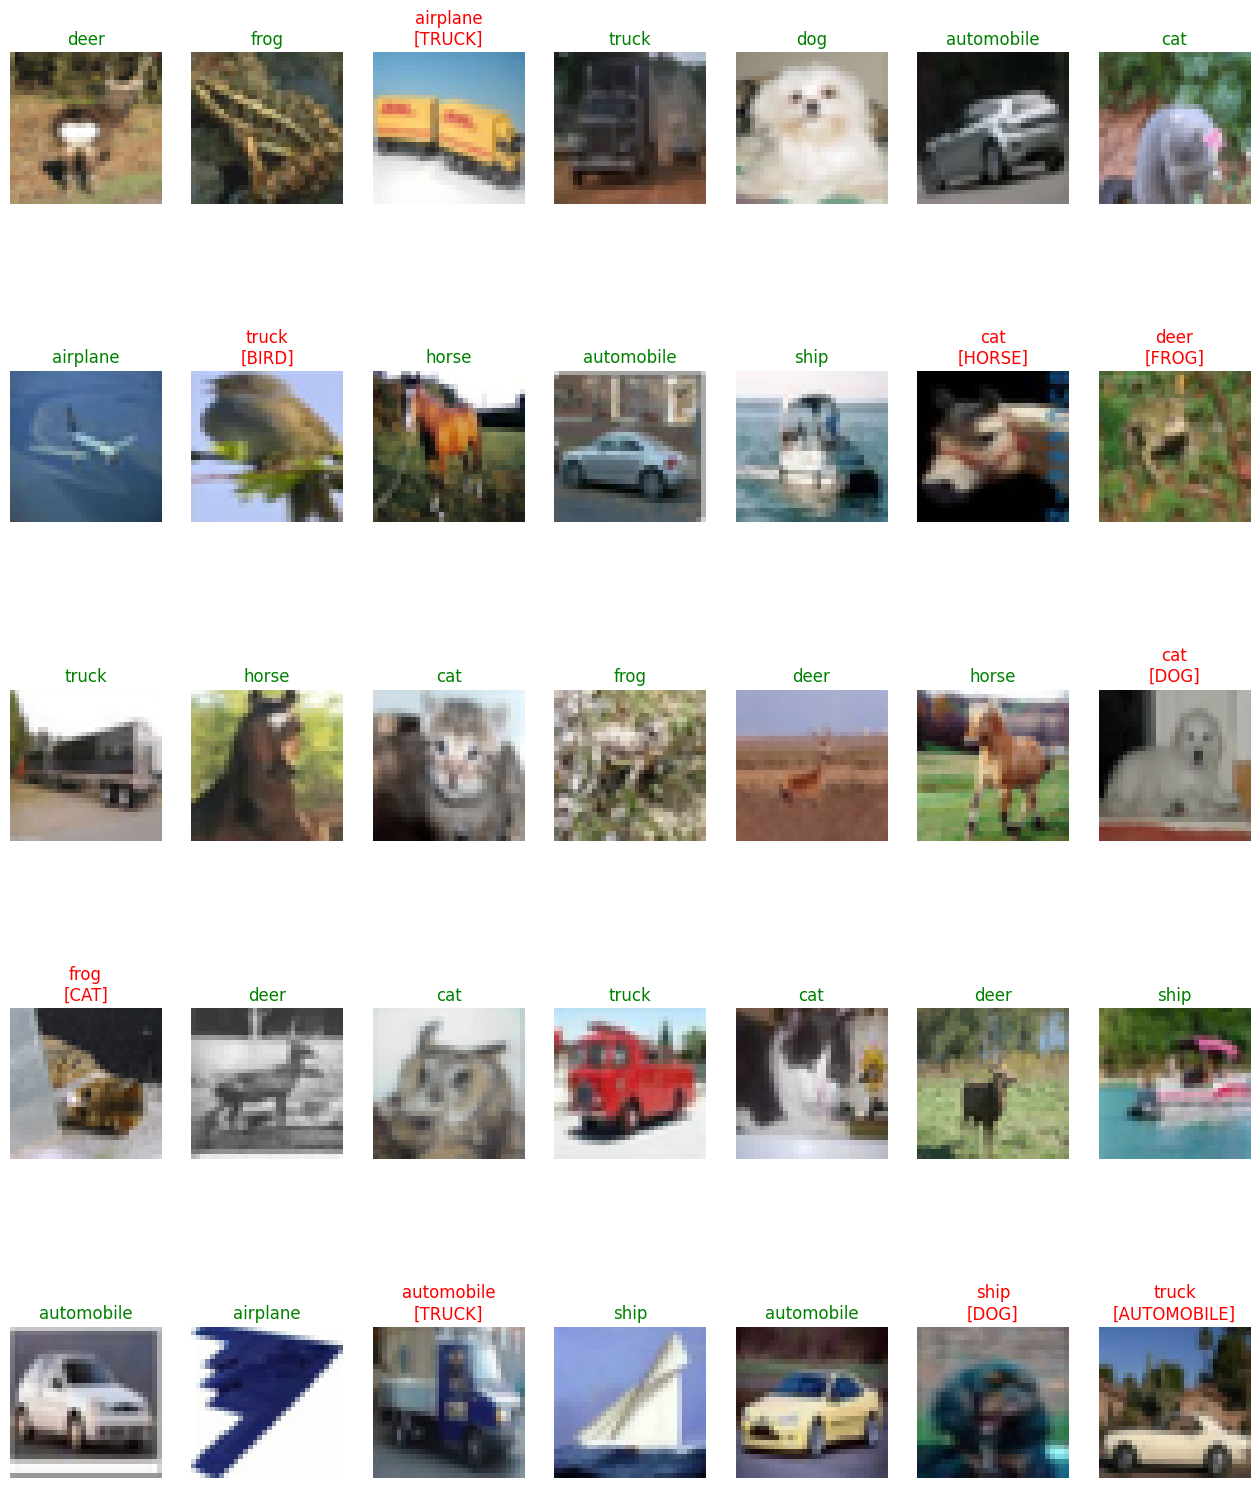

In [23]:
n_show, n_cols = 35, 7

n_rows = np.ceil(n_show/n_cols).astype(int)

plt.figure(figsize=(16,4*n_rows,))
for n,i in enumerate( rng.permutation(len(image_test))[:n_show] ):
    img = image_test[i]
    
    er = target_test[i]==o_test[i]
    t_mark = class_names[target_test[i]] 
    t_pred = class_names[o_test[i]] 
    t,c = (t_mark,'g') if er else (f'{t_pred}\n[{t_mark.upper()}]','r')
   
    plt.subplot(n_rows,n_cols,n+1)
    plt.axis(False)
    plt.title(t,color=c)
    plt.imshow(img,cmap='gray_r')